In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos
import sw_and_int_one_sess as sios

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_disinhibition_cosw'
figdir = misc.get_or_create_subdir(figdir)

In [4]:
fn = 'prepped_data_agg.p'
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [5]:
import switch_detection_sweep_penalty_one_session as sdspos
import get_all_switch_add_metrics_pen as gasamp
reload(gasamp)
pen=0.5#0.3#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}
all_sw_d_all={}
all_sw_with_metrics_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    
    sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
    if sw_info_res_pelt is None:
        sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res_pelt['all_sw_d_pen'][pen]
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res_pelt['all_sw_with_metrics_d_pen'][pen]
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d
    
    all_sw_res= gasamp.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

all_sw_d_all=pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info_pe

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/all_sw_info_pen.p ex

In [6]:
import sw_and_int_withreg as saiw
reload(saiw)

import peer_prediction as pp
reload(sios)
consec_trial_fr_diff_all = {}
sustained_all = {}
transient_all={}
all_sw_with_inh_change_all = {}
glm_res_df_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_and_int_res=saiw.main(data_dir_full,force_reload=False,load_only=True)
    consec_trial_fr_diff=sw_and_int_res['consec_trial_fr_diff_all']
    sustained=sw_and_int_res['sustained']
    transient =sw_and_int_res['transient']
    consec_trial_fr_diff_all[ani,sess] = consec_trial_fr_diff
    sustained_all[ani,sess] = sustained
    transient_all[ani,sess] = transient
    
    all_sw_with_inh_change = sw_and_int_res['all_sw_with_metrics_oneti_with_inh_change']
    all_sw_with_inh_change_all[ani,sess]=all_sw_with_inh_change
    
    glm_res_df = sw_and_int_res['glm_res_df']
    glm_res_df_all[ani,sess] = glm_res_df



glm_res_df_all = pd.concat(glm_res_df_all,axis=0)
all_sw_with_inh_change_all=pd.concat(all_sw_with_inh_change_all,axis=0)
    
consec_trial_fr_diff_all = pd.concat(consec_trial_fr_diff_all,axis=0)
sustained_all = pd.concat(sustained_all,axis=0)
transient_all = pd.concat(transient_all,axis=0)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/sw_and_int_exclude_sw_large

In [7]:
ani='e15_13f1'
sess_l = all_sw_with_inh_change_all.index.get_level_values(1).unique()
sess = 'e15_13f1_220118'#sess_l[1]

all_fields_recombined_one = all_fields_recombined_all.loc[ani,sess]

/tmp/ipykernel_1410518/2456122114.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_recombined_one = all_fields_recombined_all.loc[ani,sess]


In [19]:
row=subdb.iloc[1]
data_dir_full = row['data_dir_full']
ani=row.name[0]
sess=row['sess_name']

In [20]:
import glob
mono_res=glob.glob(os.path.join(data_dir_full,'*mono_res*'))[0]
mono_res = dpn.loadmat_full(mono_res,'mono_res')

# get both exc and inh mono

In [185]:
import get_mono_con as gmc
reload(gmc)

<module 'get_mono_con' from '/mnt/home/szheng/projects/util_code/get_mono_con.py'>

In [186]:

ccg= mono_res['ccgR']
exc_res_l, inh_res_l = gmc.get_mono_con(ccg=ccg,cell_cols=cell_cols_d['all'])

100%|██████████| 376/376 [01:43<00:00,  3.62it/s]


In [191]:
(mono_mat != exc_res_l).sum()

1.0       2
2.0      11
3.0       5
4.0      23
5.0       3
         ..
372.0     2
373.0     7
374.0     8
375.0     4
376.0     3
Length: 376, dtype: int64

In [181]:
ma=mono_mat.T.loc[:,3]!=exc_res_l.loc[:,3]
exc_res_l.loc[ma,3]

2.0      1.0
22.0     1.0
26.0     1.0
33.0     1.0
37.0     1.0
45.0     1.0
62.0     1.0
67.0     0.0
74.0     1.0
94.0     1.0
100.0    1.0
124.0    1.0
155.0    1.0
164.0    1.0
166.0    1.0
172.0    1.0
189.0    1.0
191.0    1.0
192.0    1.0
193.0    1.0
197.0    1.0
201.0    1.0
205.0    1.0
216.0    1.0
224.0    1.0
231.0    1.0
249.0    1.0
251.0    1.0
257.0    1.0
265.0    1.0
276.0    1.0
280.0    1.0
282.0    1.0
283.0    1.0
285.0    1.0
316.0    1.0
328.0    1.0
336.0    1.0
342.0    1.0
346.0    1.0
358.0    1.0
361.0    1.0
363.0    1.0
Name: 3.0, dtype: float64

In [183]:
mono_mat.T.loc[ma,3]

2.0      0.0
22.0     0.0
26.0     0.0
33.0     0.0
37.0     0.0
45.0     0.0
62.0     0.0
67.0     1.0
74.0     0.0
94.0     0.0
100.0    0.0
124.0    0.0
155.0    0.0
164.0    0.0
166.0    0.0
172.0    0.0
189.0    0.0
191.0    0.0
192.0    0.0
193.0    0.0
197.0    0.0
201.0    0.0
205.0    0.0
216.0    0.0
224.0    0.0
231.0    0.0
249.0    0.0
251.0    0.0
257.0    0.0
265.0    0.0
276.0    0.0
280.0    0.0
282.0    0.0
283.0    0.0
285.0    0.0
316.0    0.0
328.0    0.0
336.0    0.0
342.0    0.0
346.0    0.0
358.0    0.0
361.0    0.0
363.0    0.0
Name: 3.0, dtype: float64

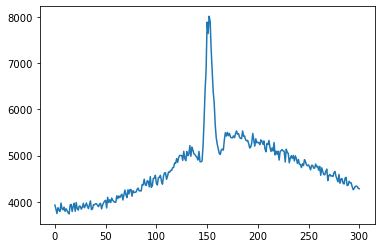

In [184]:
plt.plot(mono_res['ccgR'][:,1,2])

# relate mono_res to peer prediction weight
mono_res: pre to post

In [31]:
load_res=dpp.load_spk_beh_df(data_dir_full)

In [35]:
cell_cols_d = load_res['cell_cols_d']

In [59]:
nuid=cell_cols_d['all'].shape[0]
mono_mat = pd.DataFrame(np.zeros((nuid,nuid)),index=cell_cols_d['all'],columns=cell_cols_d['all'])

In [60]:
sig_con_exc = mono_res['sig_con_excitatory_all']

In [61]:
for pair in sig_con_exc:
    mono_mat.loc[pair[0],pair[1]]=1
mono_mat = mono_mat.T # flip to match convention for connectivity (post, pre)

In [64]:
# subselect the pyr->int part
mono_mat_sub = mono_mat.loc[cell_cols_d['int'],cell_cols_d['pyr']]

In [75]:
glm_res_df_one = glm_res_df_all.loc[ani,sess].dropna(axis=1,how='all')
coef_one = glm_res_df_one['coef'].T

/tmp/ipykernel_1410518/318730536.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  glm_res_df_one = glm_res_df_all.loc[ani,sess].dropna(axis=1,how='all')


In [92]:
coef_one_reduced = coef_one.groupby(level=(1),axis=1).mean().loc[mono_mat_sub.index]


4      5      6      7      8      9      10     11     12   \
0.0  31  1  False   True   True  False   True  False  False  False  False   
     32  1  False  False   True   True  False  False  False   True   True   
     34  0   True  False  False  False  False  False   True  False  False   
     35  1  False  False  False  False   True  False   True  False   True   
     36  0  False  False  False  False  False  False  False   True  False   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
both 363 0  False  False  False   True  False  False  False   True  False   
     368 0  False  False   True  False  False  False   True  False  False   
     370 0   True   True  False  False  False  False  False  False  False   
     374 0  False   True  False  False   True  False   True  False  False   
     376 0   True   True   True  False  False  False  False   True  False   

              13   ...    29     30     45     46     48     52     53   \
0.0  31  1   True  ...  False  False  False  False  False   True  False   
     32  1   True  ...  False  False  False   True   True   True  False   
     34  0  False  ...  False  False  False  False  False  False  False   
     35  1  False  ...  False  False  False   True  False  False  False   
     36  0  False  ...  False  False  False  False   True  False  False   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
both 363 0   True  ...  False  False  False   True  False  False  False   
     368 0   True  ...  False  False   True  False  False  False  False   
     370 0   True  ...   True  False   True  False  False  False  False   
     374 0   True  ...  False  False  False   True  False  False  False   
     376 0   True  ...  False   True   True  False  False  False  False   

              58     109    205  
0.0  31  1   True  False  False  
     32  1  False  False  False  
     34  0  False   True  False  
     35  1  False   True  False  
     36  0  False  False   True  
...           ...    ...    ...  
both 363 0  False  False  False  
     368 0  False  False  False  
     370 0  False  False   True  
     374 0  False  False  False  
     376 0  False  False   True  

[682 rows x 43 columns]

In [201]:
con_from_coef = 1* ((glm_res_df_one['p'] < 0.05)&(glm_res_df_one['coef']>0)).astype(int) + \
                    (-1) * ((glm_res_df_one['p'] < 0.05)&(glm_res_df_one['coef']<0)).astype(int)


In [207]:
con_from_coef_reduced = con_from_coef.groupby(level=1).mean()

In [217]:
exc_from_coef = con_from_coef_reduced > 0
inh_from_coef = con_from_coef_reduced < 0

In [219]:
exc_res_l_sub = exc_res_l.loc[con_from_coef_reduced.columns,con_from_coef_reduced.index]
inh_res_l_sub = inh_res_l.loc[con_from_coef_reduced.index,con_from_coef_reduced.columns]

In [227]:
from scipy.spatial.distance import pdist,cdist, squareform

In [280]:
mono_onetype=exc_res_l_sub#inh_res_l_sub
coef_onetype=exc_from_coef.T#inh_from_coef

data_dist=np.diag(cdist(mono_onetype,coef_onetype,metric='jaccard'))

In [283]:

data_dist

array([0.96875   , 0.69387755, 0.76774194, 0.88636364, 0.96078431,
       0.7032967 , 0.75      , 0.72020725, 0.77205882, 0.68041237,
       0.48971193, 0.72049689, 0.57435897, 0.78472222, 0.60714286,
       0.79365079, 0.73658537, 0.64529915, 0.72857143, 0.68108108,
       0.87857143, 0.78125   , 1.        , 0.92307692, 0.6147541 ,
       0.86330935, 0.84466019, 0.875     , 0.79487179, 0.80392157,
       0.86956522, 0.81102362, 0.84269663, 0.96103896, 0.72340426,
       0.7253886 , 0.97      , 0.92391304, 0.97468354, 0.89473684,
       0.98591549, 0.84693878, 1.        ])

In [372]:
exc_res_l_sub.iloc[12]

31.0     1.0
32.0     1.0
34.0     1.0
35.0     0.0
36.0     1.0
        ... 
371.0    0.0
373.0    1.0
374.0    1.0
375.0    0.0
376.0    1.0
Name: 16.0, Length: 270, dtype: float64

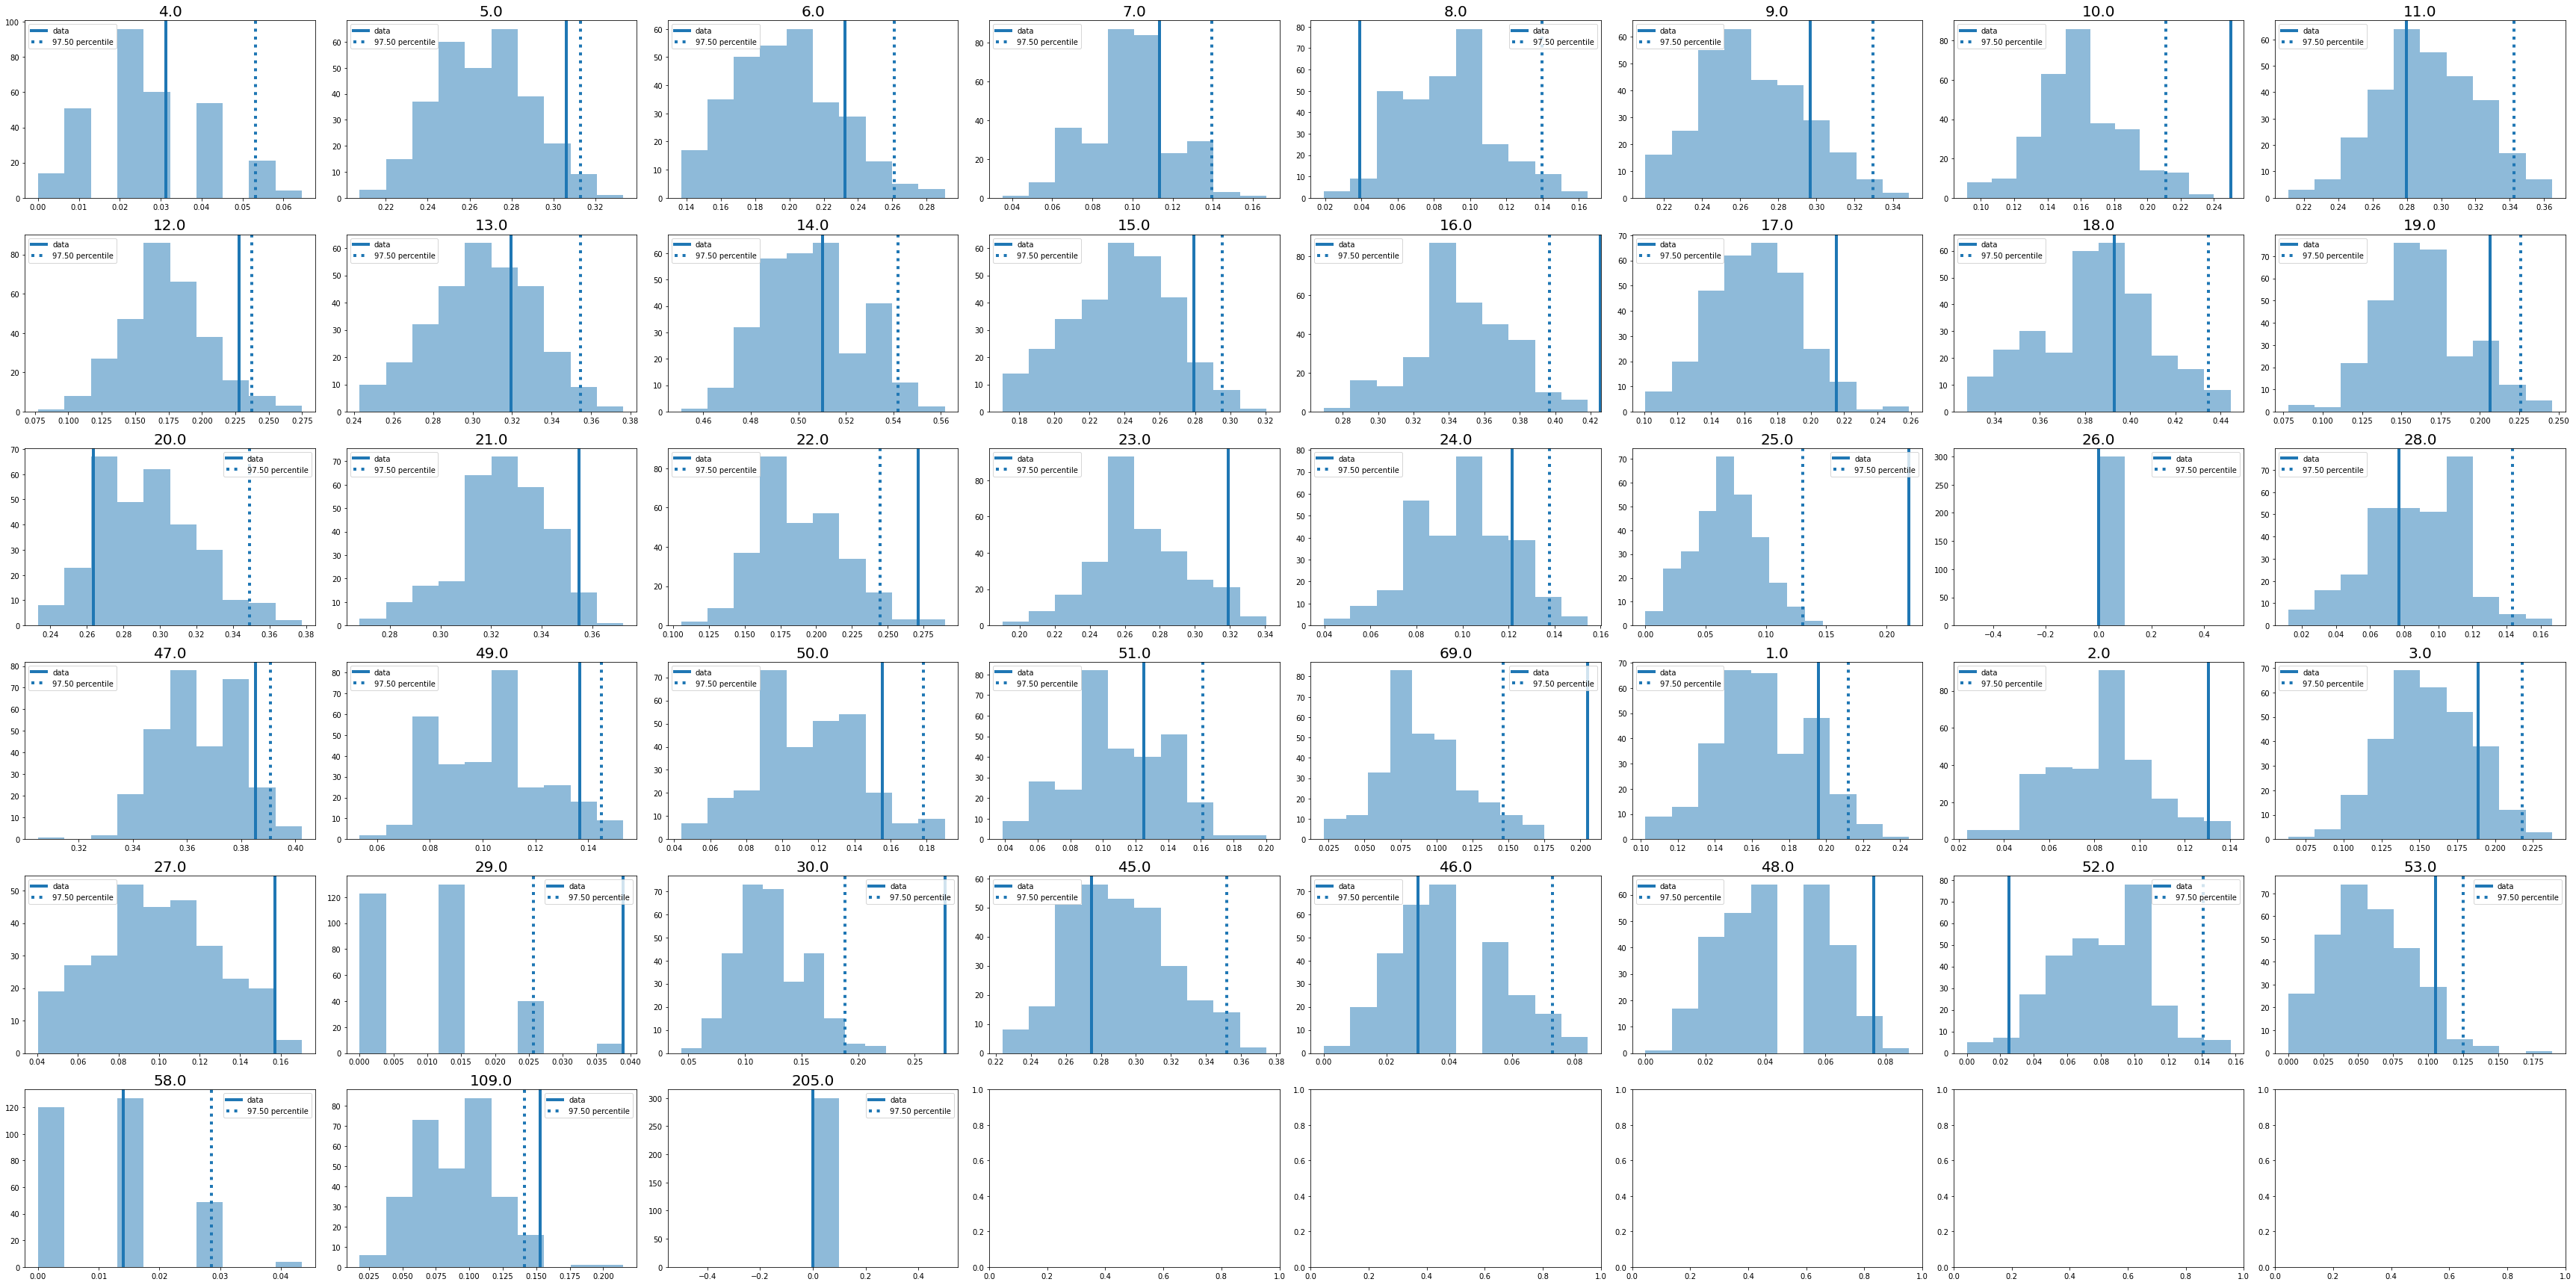

In [378]:
mono_onetype=exc_res_l_sub#inh_res_l_sub
coef_onetype=exc_from_coef.T#inh_from_coef

data_dist=np.diag(cdist(mono_onetype,coef_onetype,metric='jaccard'))

nplots = exc_res_l_sub.shape[0]
fig,axs=ph.subplots_wrapper(nplots)

nrepeats = 300
for ii in range(nplots):
    ax=axs.ravel()[ii]
#     ii=17
    exc_res_l_sub_sh = []
    exc_from_coef_sh = []
    for i in range(nrepeats):
        exc_res_l_sub_sh.append(exc_res_l_sub.iloc[ii].sample(frac=1).values)
        exc_from_coef_sh.append(exc_from_coef.T.iloc[ii].sample(frac=1).values)
    exc_res_l_sub_sh = np.array(exc_res_l_sub_sh)
    exc_from_coef_sh = np.array(exc_from_coef_sh)

    null=np.diag(cdist(exc_res_l_sub_sh,exc_from_coef_sh,metric='jaccard'))
    ph.plot_shuffle_data_dist_with_thresh(1-null,1-data_dist[ii],ax=ax)
    ax.set_title(exc_res_l_sub.index[ii])
plt.tight_layout()

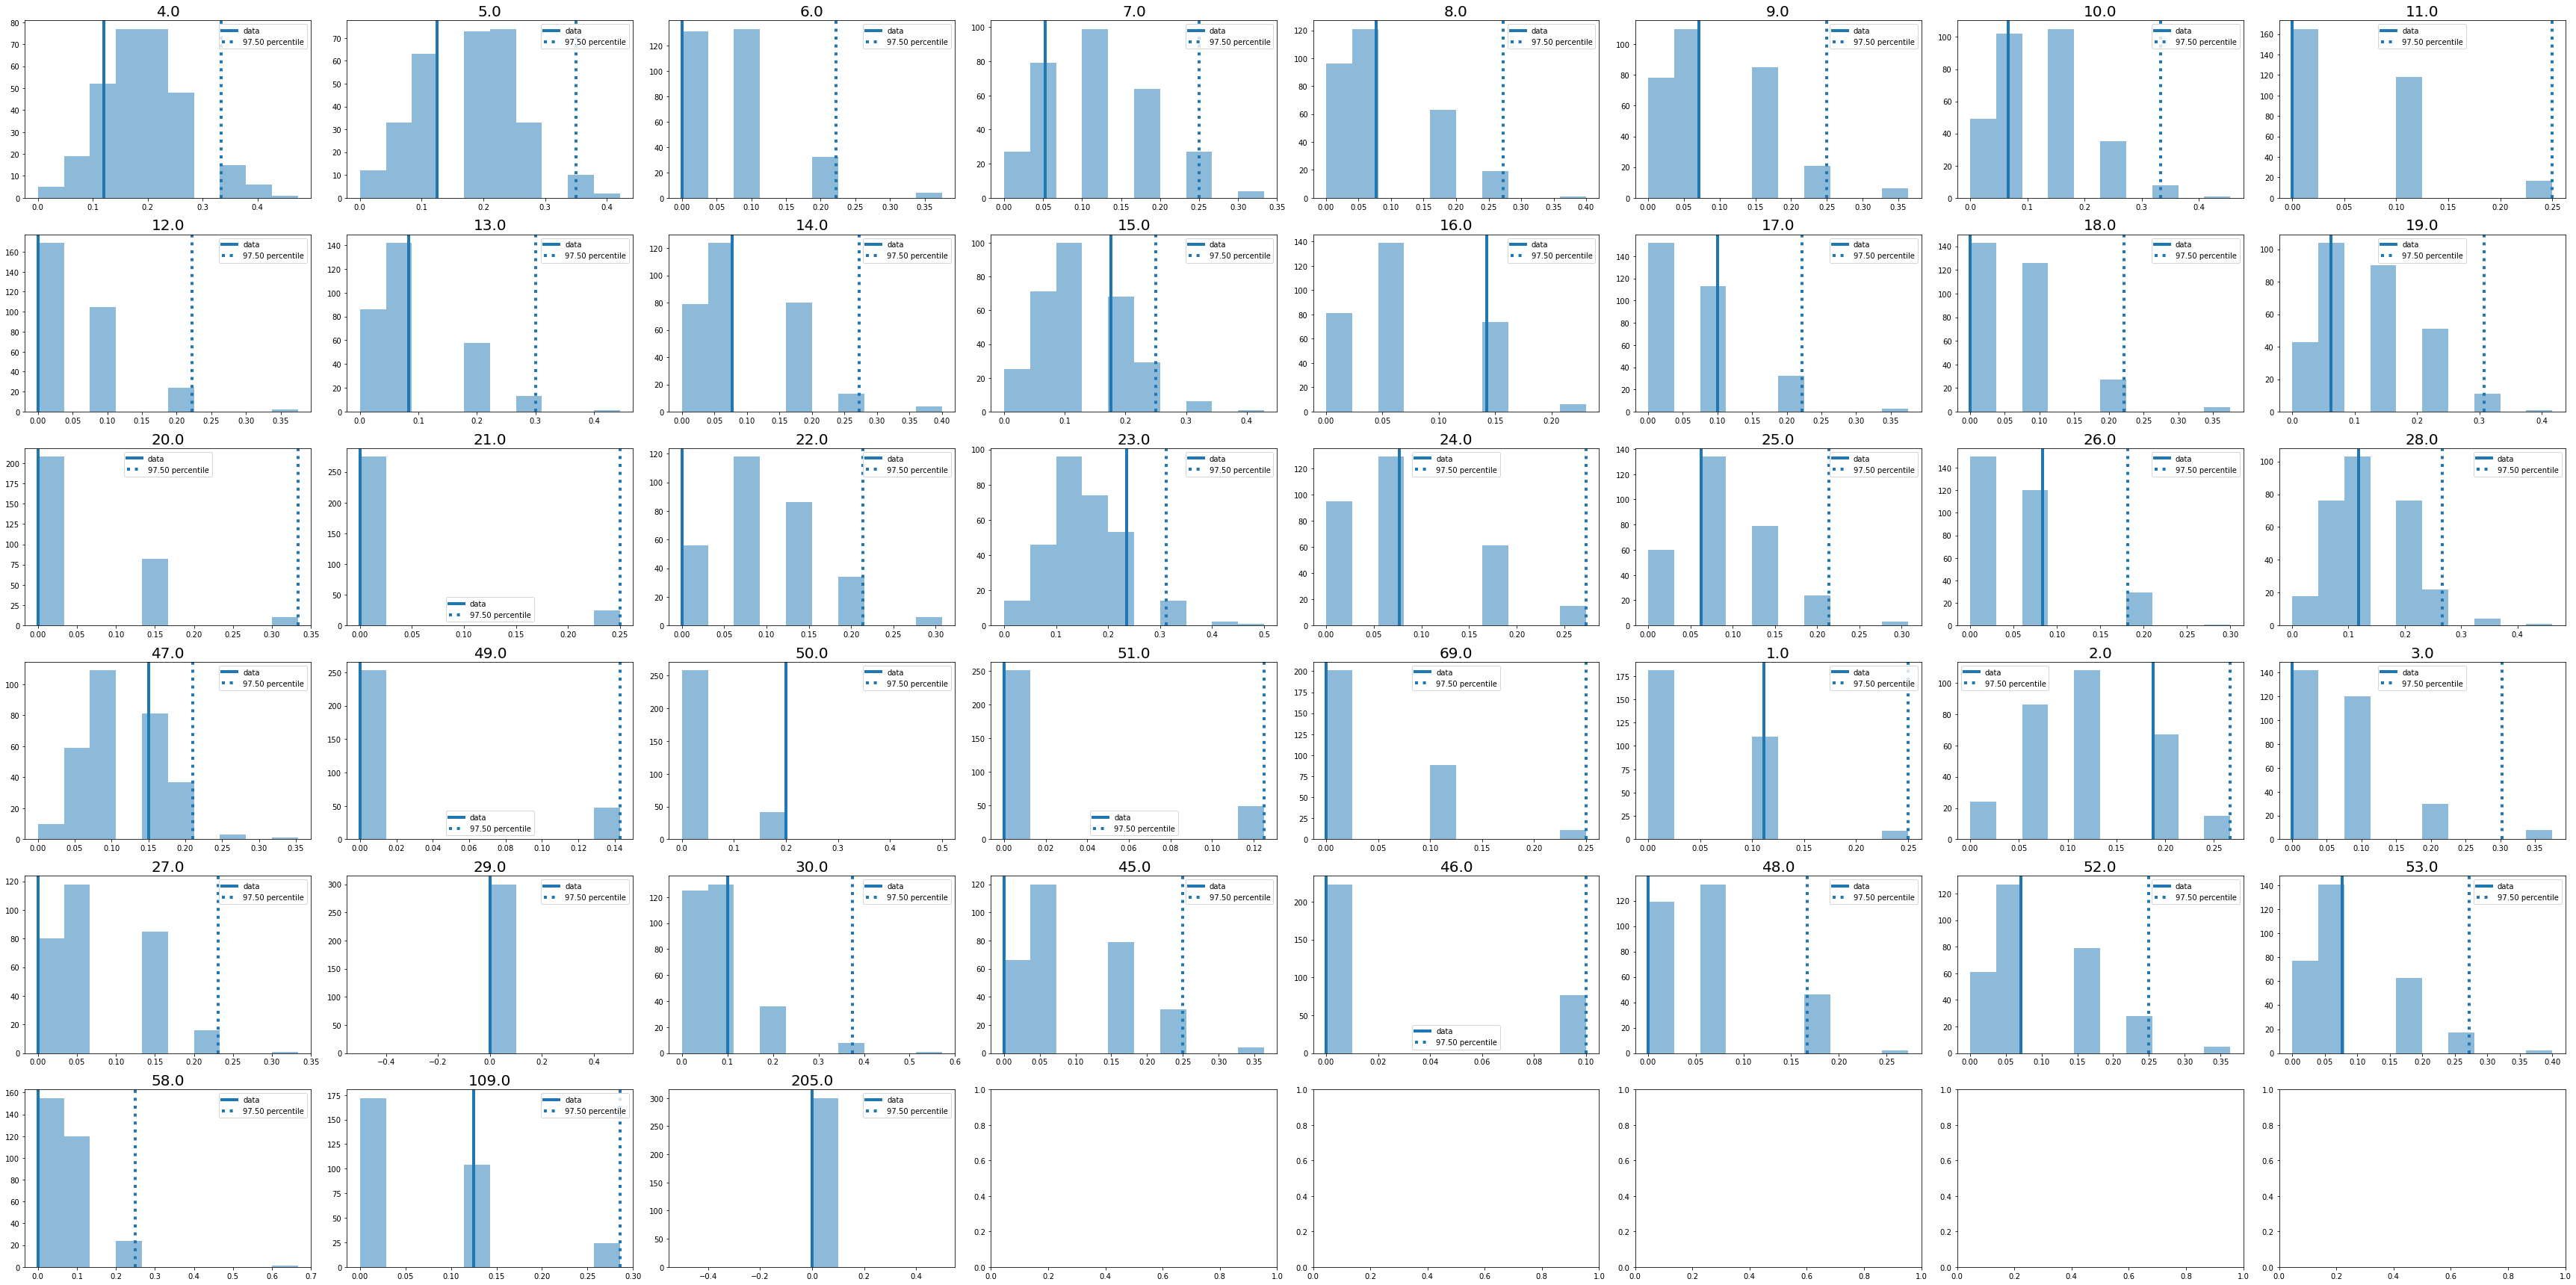

In [379]:
mono_onetype=inh_res_l_sub
coef_onetype=inh_from_coef

data_dist=np.diag(cdist(mono_onetype,coef_onetype,metric='jaccard'))

nplots = exc_res_l_sub.shape[0]
fig,axs=ph.subplots_wrapper(nplots)

nrepeats = 300

for ii in range(nplots):
    ax=axs.ravel()[ii]
    inh_res_l_sub_sh = []
    inh_from_coef_sh = []

    for i in range(nrepeats):
        inh_res_l_sub_sh.append(inh_res_l_sub.iloc[ii].sample(frac=1).values)
        inh_from_coef_sh.append(inh_from_coef.iloc[ii].sample(frac=1).values)
    inh_res_l_sub_sh = np.array(inh_res_l_sub_sh)
    inh_from_coef_sh = np.array(inh_from_coef_sh)
    null=np.diag(cdist(inh_res_l_sub_sh,inh_from_coef_sh,metric='jaccard'))
    ph.plot_shuffle_data_dist_with_thresh(1-null,1-data_dist[ii],ax=ax)
    ax.set_title(exc_res_l_sub.index[ii])
plt.tight_layout()


(<Figure size 432x288 with 1 Axes>, <Axes: >)

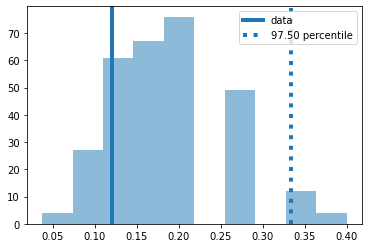

In [366]:
mono_onetype=inh_res_l_sub
coef_onetype=inh_from_coef

data_dist=np.diag(cdist(mono_onetype,coef_onetype,metric='jaccard'))

nrepeats = 300
ii=0
inh_res_l_sub_sh = []
inh_from_coef_sh = []
for i in range(nrepeats):
    inh_res_l_sub_sh.append(inh_res_l_sub.iloc[ii].sample(frac=1).values)
    inh_from_coef_sh.append(inh_from_coef.iloc[ii].sample(frac=1).values)
inh_res_l_sub_sh = np.array(inh_res_l_sub_sh)
inh_from_coef_sh = np.array(inh_from_coef_sh)
null=np.diag(cdist(inh_res_l_sub_sh,inh_from_coef_sh,metric='jaccard'))
ph.plot_shuffle_data_dist_with_thresh(1-null,1-data_dist[ii])


(<Figure size 432x288 with 1 Axes>, <Axes: >)

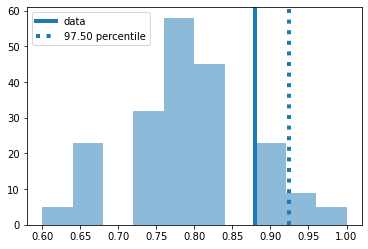

In [244]:
cdist()

(100, 43)

In [242]:
inh_res_l_sub_sh

[9.0      1.0
 26.0     0.0
 109.0    0.0
 1.0      0.0
 2.0      0.0
 20.0     1.0
 205.0    0.0
 22.0     0.0
 28.0     1.0
 45.0     0.0
 30.0     0.0
 49.0     0.0
 15.0     1.0
 69.0     1.0
 6.0      1.0
 17.0     1.0
 11.0     1.0
 5.0      0.0
 12.0     1.0
 16.0     0.0
 51.0     0.0
 47.0     1.0
 48.0     0.0
 46.0     0.0
 50.0     0.0
 25.0     0.0
 14.0     1.0
 10.0     0.0
 7.0      0.0
 4.0      0.0
 18.0     0.0
 3.0      0.0
 24.0     0.0
 23.0     1.0
 58.0     0.0
 29.0     0.0
 21.0     1.0
 13.0     1.0
 27.0     0.0
 53.0     0.0
 8.0      0.0
 52.0     1.0
 19.0     0.0
 Name: 31.0, dtype: float64,
 53.0     0.0
 9.0      1.0
 17.0     1.0
 16.0     0.0
 1.0      0.0
 49.0     0.0
 47.0     1.0
 20.0     1.0
 51.0     0.0
 46.0     0.0
 24.0     0.0
 23.0     1.0
 10.0     0.0
 5.0      0.0
 18.0     0.0
 12.0     1.0
 22.0     0.0
 6.0      1.0
 52.0     1.0
 11.0     1.0
 45.0     0.0
 13.0     1.0
 30.0     0.0
 8.0      0.0
 50.0     0.0
 26.0     0.0
 58.0

In [ ]:
inh

In [216]:
exc_from_coef.T

,31,32,34,35,36,37,38,40,41,42,...,366,367,368,369,370,371,373,374,375,376
4,False,False,True,False,False,False,False,True,True,False,...,False,False,False,False,True,True,True,False,True,True
5,True,True,False,False,False,False,True,False,False,True,...,False,False,False,False,True,True,False,True,False,True
6,True,True,True,False,False,False,True,False,True,True,...,False,False,True,False,False,False,False,False,False,True
7,False,True,False,True,False,True,True,False,True,True,...,False,False,False,True,False,False,False,False,True,False
8,True,True,False,True,True,False,True,True,False,False,...,False,True,False,False,False,False,True,True,False,False
9,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
10,False,False,True,True,False,False,True,False,False,False,...,True,True,True,False,False,False,False,True,False,False
11,True,True,False,False,True,False,False,False,True,True,...,True,False,False,False,False,False,True,False,False,True
12,False,True,False,True,False,False,True,False,False,False,...,False,False,True,True,False,False,True,False,False,False
13,True,True,False,False,False,True,False,True,True,True,...,True,False,True,False,True,False,False,True,True,True


In [214]:
exc_res_l_sub

,31.0,32.0,34.0,35.0,36.0,37.0,38.0,40.0,41.0,42.0,...,366.0,367.0,368.0,369.0,370.0,371.0,373.0,374.0,375.0,376.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
6.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
11.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
12.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
13.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [205]:
exc_res_l

,31.0,32.0,34.0,35.0,36.0,37.0,38.0,40.0,41.0,42.0,...,366.0,367.0,368.0,369.0,370.0,371.0,373.0,374.0,375.0,376.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
6.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


In [202]:
con_from_coef

4    5    6    7    8    9    10   11   12   13   ...  29   30   \
0.0  31  1    0    1    1   -1    1   -1   -1    0   -1    1  ...    0    0   
     32  1   -1    0    1    1    0   -1   -1    1    1    1  ...   -1    0   
     34  0    1    0    0    0    0   -1    1    0    0    0  ...    0    0   
     35  1   -1    0    0    0    1   -1    1    0    1   -1  ...   -1    0   
     36  0    0   -1    0    0    0    0    0    1    0   -1  ...   -1    0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
both 363 0    0   -1    0    1    0    0    0    1    0    1  ...    0    0   
     368 0    0    0    1   -1   -1    0    1   -1    0    1  ...    0   -1   
     370 0    1    1   -1    0   -1    0    0    0   -1    1  ...    1    0   
     374 0    0    1    0   -1    1   -1    1    0   -1    1  ...   -1   -1   
     376 0    1    1    1   -1    0   -1   -1    1    0    1  ...   -1    1   

            45   46   48   52   53   58   109  205  
0.0  31  1   -1   -1    0    1    0    1    0    0  
     32  1   -1    1    1    1    0   -1    0    0  
     34  0    0    0    0    0    0   -1    1    0  
     35  1   -1    1    0   -1    0    0    1    0  
     36  0    0   -1    1   -1    0    0    0    1  
...         ...  ...  ...  ...  ...  ...  ...  ...  
both 363 0    0    1   -1    0    0    0    0    0  
     368 0    1    0   -1    0    0    0    0   -1  
     370 0    1    0    0    0   -1    0    0    1  
     374 0   -1    1    0    0    0   -1   -1   -1  
     376 0    1    0   -1    0    0    0    0    1  

[682 rows x 43 columns]

In [194]:
coef_one_reduced

,31,32,34,35,36,37,38,40,41,42,...,366,367,368,369,370,371,373,374,375,376
1,0.008748,-0.001534,-0.000378,-0.004052,0.010516,0.002000,-0.000561,-0.000780,-0.014291,0.007572,...,0.001823,0.005788,-0.004080,-0.001839,0.002553,0.000506,0.001485,-0.003971,0.001883,0.000269
2,0.000280,-0.005736,0.000932,0.002935,-0.002988,0.000592,0.000824,0.006924,-0.007538,-0.001426,...,0.001078,-0.001267,-0.003978,-0.000642,-0.002371,0.000815,-0.000795,0.002391,-0.001397,-0.004393
3,0.003218,-0.014900,-0.002501,0.014914,-0.001596,0.000160,0.004816,0.005678,0.004181,0.000906,...,0.005642,-0.001570,-0.000246,0.000642,-0.000806,0.001679,0.000714,0.000578,-0.001933,-0.007646
4,-0.004966,-0.008085,0.000574,-0.003378,-0.000485,-0.001726,-0.005345,0.001406,0.003197,-0.004835,...,-0.003850,-0.000760,-0.003537,-0.002055,0.002155,0.003517,0.003008,-0.000969,0.001842,0.005507
5,0.014095,0.002739,-0.007570,-0.002593,-0.009550,0.000666,0.008589,0.000499,0.002228,0.004468,...,-0.003064,-0.001359,0.001524,-0.001378,0.001422,0.001949,-0.002638,0.015186,-0.002788,0.003596
6,0.014417,0.003648,0.007086,0.000232,0.001151,-0.000695,0.002923,-0.000783,0.009088,0.003131,...,-0.000019,-0.000838,0.010729,0.001174,-0.001040,-0.002639,0.000368,-0.000875,-0.000014,0.003431
7,0.004074,0.008486,-0.000266,0.003009,-0.001989,0.006295,0.002940,0.000352,0.003399,0.002846,...,-0.004012,-0.000578,-0.002863,0.004055,0.000731,0.000407,-0.000691,-0.004263,0.001018,-0.001576
8,0.002677,0.004214,-0.001085,0.005403,0.001933,-0.000309,0.007112,0.000384,-0.008172,0.000412,...,-0.005831,0.002430,-0.005202,0.001121,-0.002233,0.000472,0.002501,0.001943,0.000316,0.000115
9,-0.001710,-0.000274,0.001546,-0.006582,0.000555,0.000884,-0.008571,-0.007309,0.004863,0.001044,...,0.004725,0.007030,-0.000730,0.000643,0.000014,0.000227,0.000389,-0.006673,-0.001290,-0.002438
10,-0.003605,-0.016624,0.011785,0.015862,0.002251,-0.001878,0.011294,0.002415,-0.020469,-0.004380,...,0.007892,0.008001,0.006555,-0.003426,0.000525,-0.000431,-0.000103,0.006798,0.000393,-0.003652


In [87]:
coef_and_mono_one = pd.concat({'coef':coef_one_reduced,'mono':mono_mat_sub},axis=1)

In [97]:
cols=coef_one_reduced.columns.intersection(mono_mat_sub.columns)
mono_mat_sub = mono_mat_sub.loc[:,cols]

In [105]:
ncols =len(cols)

In [108]:
coef_one_reduced

,31,32,34,35,36,37,38,40,41,42,...,366,367,368,369,370,371,373,374,375,376
1,0.008748,-0.001534,-0.000378,-0.004052,0.010516,0.002000,-0.000561,-0.000780,-0.014291,0.007572,...,0.001823,0.005788,-0.004080,-0.001839,0.002553,0.000506,0.001485,-0.003971,0.001883,0.000269
2,0.000280,-0.005736,0.000932,0.002935,-0.002988,0.000592,0.000824,0.006924,-0.007538,-0.001426,...,0.001078,-0.001267,-0.003978,-0.000642,-0.002371,0.000815,-0.000795,0.002391,-0.001397,-0.004393
3,0.003218,-0.014900,-0.002501,0.014914,-0.001596,0.000160,0.004816,0.005678,0.004181,0.000906,...,0.005642,-0.001570,-0.000246,0.000642,-0.000806,0.001679,0.000714,0.000578,-0.001933,-0.007646
4,-0.004966,-0.008085,0.000574,-0.003378,-0.000485,-0.001726,-0.005345,0.001406,0.003197,-0.004835,...,-0.003850,-0.000760,-0.003537,-0.002055,0.002155,0.003517,0.003008,-0.000969,0.001842,0.005507
5,0.014095,0.002739,-0.007570,-0.002593,-0.009550,0.000666,0.008589,0.000499,0.002228,0.004468,...,-0.003064,-0.001359,0.001524,-0.001378,0.001422,0.001949,-0.002638,0.015186,-0.002788,0.003596
6,0.014417,0.003648,0.007086,0.000232,0.001151,-0.000695,0.002923,-0.000783,0.009088,0.003131,...,-0.000019,-0.000838,0.010729,0.001174,-0.001040,-0.002639,0.000368,-0.000875,-0.000014,0.003431
7,0.004074,0.008486,-0.000266,0.003009,-0.001989,0.006295,0.002940,0.000352,0.003399,0.002846,...,-0.004012,-0.000578,-0.002863,0.004055,0.000731,0.000407,-0.000691,-0.004263,0.001018,-0.001576
8,0.002677,0.004214,-0.001085,0.005403,0.001933,-0.000309,0.007112,0.000384,-0.008172,0.000412,...,-0.005831,0.002430,-0.005202,0.001121,-0.002233,0.000472,0.002501,0.001943,0.000316,0.000115
9,-0.001710,-0.000274,0.001546,-0.006582,0.000555,0.000884,-0.008571,-0.007309,0.004863,0.001044,...,0.004725,0.007030,-0.000730,0.000643,0.000014,0.000227,0.000389,-0.006673,-0.001290,-0.002438
10,-0.003605,-0.016624,0.011785,0.015862,0.002251,-0.001878,0.011294,0.002415,-0.020469,-0.004380,...,0.007892,0.008001,0.006555,-0.003426,0.000525,-0.000431,-0.000103,0.006798,0.000393,-0.003652


In [109]:
mono_mat_sub

,31.0,32.0,34.0,35.0,36.0,37.0,38.0,40.0,41.0,42.0,...,366.0,367.0,368.0,369.0,370.0,371.0,373.0,374.0,375.0,376.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
6.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


In [112]:
coef_one_reduced.shape
corr = np.corrcoef(coef_one_reduced.T,mono_mat_sub.T)[:ncols,ncols:]

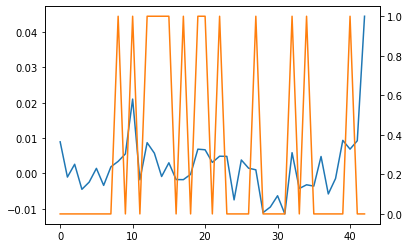

In [144]:
fig,ax=plt.subplots()
ax.plot(coef_one_reduced.iloc[:,ii].values)
ax2=ax.twinx()
ax2.plot(mono_mat_sub.iloc[:,ii].values,c='C1')

(<Figure size 432x288 with 1 Axes>, <Axes: >)

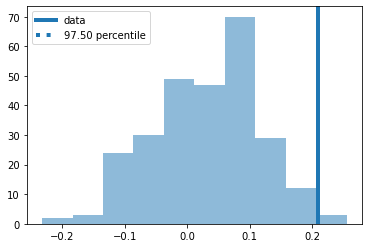

In [135]:
ii=18

ph.plot_shuffle_data_dist_with_thresh(corr[ii,:],corr[ii,ii])

In [89]:
coef_and_mono_one.rcorr()

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))

KeyboardInterrupt



In [85]:
mono_mat_sub

,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,...,367.0,368.0,369.0,370.0,371.0,372.0,373.0,374.0,375.0,376.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
6.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


In [51]:
mono_mat

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,367.0,368.0,369.0,370.0,371.0,372.0,373.0,374.0,375.0,376.0
1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
374.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
pair

array([345., 331.])

In [47]:
mono_mat.loc[sig_con_exc[:,0]][sig_con_exc[:,1]]

,2.0,3.0,5.0,6.0,8.0,9.0,11.0,12.0,13.0,14.0,...,231.0,256.0,253.0,256.0,256.0,271.0,356.0,368.0,326.0,331.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
mono_res[
    'sig_con'
]

array([[  1.,   2.],
       [  1.,   3.],
       [  1.,   5.],
       ...,
       [281., 368.],
       [319., 326.],
       [345., 331.]])

In [53]:
mono_res['sig_con_excitatory']

array([[  1.,   2.],
       [  1.,   3.],
       [  1.,   5.],
       ...,
       [281., 368.],
       [319., 326.],
       [345., 331.]])

In [25]:
mono_res['sig_con_excitatory_all']

array([[  1.,   2.],
       [  1.,   3.],
       [  1.,   5.],
       ...,
       [281., 368.],
       [319., 326.],
       [345., 331.]])